In [2]:
#import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from time import time
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
sns.set()
%matplotlib inline

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [108]:
#
print('Train Shape:', train.shape)
print('Train Shape:', train.shape)

Train Shape: (200000, 202)


In [5]:
# Total number of records
n_records = len(train)

# Number of records where the client made the transaction
made = train.target.sum()

# Number of records where the client didn't make the transaction
didnt_make = n_records - made

# Percentage of transaction made
percentage = made / n_records 

# Print the results
print("Total number of records: {}".format(n_records))
print("Clients that made the transaction: {}".format(made))
print("Clients that didn't make the transaction: {}".format(didnt_make))
print("Percentage of clients that made the transaction: {}%".format(percentage*100))

Total number of records: 200000
Clients that made the transaction: 20098
Clients that didn't make the transaction: 179902
Percentage of clients that made the transaction: 10.049%


In [6]:
#Setting up X and y
train_data = train.copy()
y = train_data.target
X = train_data.drop(['ID_code', 'target'], axis=1)

# Preprocessing the data

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

In [93]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, 
                                                    y, 
                                                    test_size = 0.5, 
                                                    random_state = 1)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 100000 samples.
Testing set has 100000 samples.


In [9]:
from xgboost import XGBClassifier

In [94]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

#cv_results = xgb.cv(dtrain=D_train, params=params, nfold=10,
#                    num_boost_round=1000,early_stopping_rounds=50,metrics="auc", as_pandas=True, seed=123)

C:\Users\eders\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


# Training and Testing

In [11]:
def model_training(dtrain, params, rounds):
    model = xgb.train(dtrain= dtrain, params= params, num_boost_round= rounds)
    return model

In [62]:
#make predictions based on probabilities and a threshold
def get_preds(probabilities, threshold):
    return [1 if x > threshold else 0 for x in probabilities]

In [101]:
def scores(dtest, y_test, model):
    probs = model.predict(dtest)
    auc = round(roc_auc_score(y_test, probs), 4)
    y_pred = get_preds(probs, 0.1)
    cm = confusion_matrix(y_test, y_pred)
    return auc, cm, y_pred

# Submission

In [51]:
def transform_data(data):
    data = data.drop(['ID_code'], axis = 1)
    scaler = StandardScaler() 
    test_features = scaler.fit_transform(data)
    final_data = xgb.DMatrix(test_features)
    return final_data

In [64]:
def make_csv(test_data, model):
    preds_final = model.predict(test_data)
    predictions = pd.Series(preds_final, index = test['ID_code'], name = 'target')
    return predictions.to_csv("submission.csv", header = True)

In [99]:
for i in np.arange(1):
    params = {
    'objective': "binary:logistic", 
    'colsample_bytree': .3, 
    'learning_rate': 0.1, 
    'max_depth': 2,
    'gamma': 10,
    'subsample': 0.8,
    'reg_alpha' : 0.4,
    'scale_pos_weight': 1,
    'tree_method': 'gpu_hist',
    'silent': 1}
    model = model_training(D_train, params, 2500)

In [102]:
auc, cm, predicted = scores(D_test, y_test, model)
print("AUC = {}".format(auc))
print('Confusion Matrix: \n', cm)
print('--------------------')
print('FPR : %', round(100 * (cm[0][1]/(cm[0][0]+cm[0][1]))))
print('TPR : %', round(100* (cm[1][1]/(cm[1][0]+cm[1][1]))))
print('PPV : %', round(100* (cm[1][1]/(cm[0][1]+cm[1][1]))))
print('---------------------------------------------------------')

AUC = 0.8943
Confusion Matrix: 
 [[74264 15765]
 [ 1974  7997]]
--------------------
FPR : % 18.0
TPR : % 80.0
PPV : % 34.0
---------------------------------------------------------


In [95]:
probs = model.predict(D_test)

In [88]:
pd.Series(probs).describe()

count    40000.000000
mean         0.097888
std          0.172977
min          0.000125
25%          0.010180
50%          0.029388
75%          0.093061
max          0.998553
dtype: float64

In [90]:
pd.Series(probs).value_counts(bins=10)

(-0.001873, 0.1]    30533
(0.1, 0.2]           4077
(0.2, 0.3]           1695
(0.3, 0.399]         1008
(0.399, 0.499]        669
(0.499, 0.599]        537
(0.599, 0.699]        433
(0.699, 0.799]        369
(0.799, 0.899]        344
(0.899, 0.999]        335
dtype: int64

In [96]:
roc_values = []
for thresh in np.linspace(0, 1, 101):
    preds = get_preds(probs, thresh)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values.append([tpr, fpr])
tpr_values, fpr_values = zip(*roc_values)

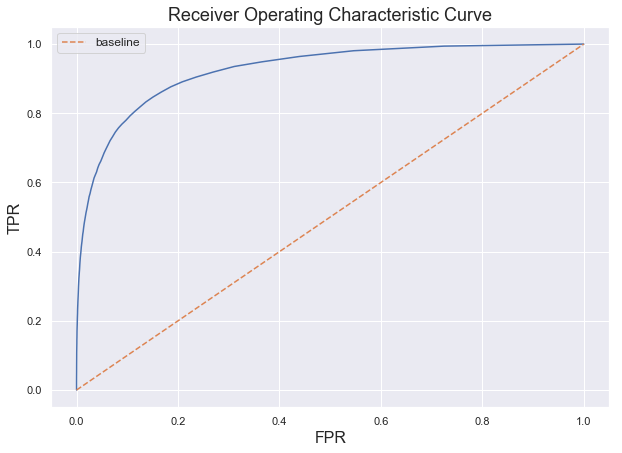

In [97]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, tpr_values)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);

In [65]:
test_data = transform_data(test)
make_csv(test_data, model)